In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [102]:
train = pd.read_csv('../investing_data/train.csv')
test = pd.read_csv('../investing_data/test.csv')

train = train.loc[:, ['datetime', 'Samsung']]
test = test.loc[:, ['datetime', 'Samsung']]

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [103]:
scaler = MinMaxScaler()
scaler.fit(train[['Samsung']])
train['Samsung'] = scaler.transform(train[['Samsung']])
test['Samsung'] = scaler.transform(test[['Samsung']])

In [104]:
seq_len = 50
sequence_length = seq_len + 1

train_result = []
for index in range(len(train['Samsung'].values) - sequence_length):
    train_result.append(train['Samsung'].values[index: index + sequence_length])
    
test_result = []
for index in range(len(test['Samsung'].values) - sequence_length):
    test_result.append(test['Samsung'].values[index: index + sequence_length])

In [105]:
train_result = np.array(train_result)
test_result = np.array(test_result)

np.random.shuffle(train_result)

In [106]:
X_train = train_result[:, :-1]
y_train = train_result[:, -1]

X_test = test_result[:, :-1]
y_test = test_result[:, -1]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [110]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(50, 1), activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 64)            16896     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 29,473
Trainable params: 29,409
Non-trainable params: 64
_________________________________________________________________


In [111]:
model.compile(loss='mse', optimizer='adam')

In [112]:
earlystop = EarlyStopping(monitor='val_loss',  
                          patience=5, 
                          verbose=1, 
                          mode='min',
                          restore_best_weights=True )
reducelr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.2, 
                             patience=5, 
                             verbose=1, 
                             mode='min')

In [113]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          validation_split=0.2,
          callbacks=[earlystop, reducelr])

Epoch 1/30
53/53 [==============================] - 4s 40ms/step - loss: 0.1234 - val_loss: 0.0505
Epoch 2/30
53/53 [==============================] - 2s 32ms/step - loss: 0.0065 - val_loss: 0.0491
Epoch 3/30
53/53 [==============================] - 2s 31ms/step - loss: 0.0065 - val_loss: 0.0472
Epoch 4/30
53/53 [==============================] - 2s 32ms/step - loss: 0.0081 - val_loss: 0.0454
Epoch 5/30
53/53 [==============================] - 2s 32ms/step - loss: 0.0068 - val_loss: 0.0427
Epoch 6/30
53/53 [==============================] - 2s 31ms/step - loss: 0.0067 - val_loss: 0.0390
Epoch 7/30
53/53 [==============================] - 2s 31ms/step - loss: 0.0060 - val_loss: 0.0351
Epoch 8/30
53/53 [==============================] - 2s 31ms/step - loss: 0.0049 - val_loss: 0.0294
Epoch 9/30
53/53 [==============================] - 2s 31ms/step - loss: 0.0061 - val_loss: 0.0273
Epoch 10/30
53/53 [==============================] - 2s 32ms/step - loss: 0.0067 - val_loss: 0.0177
Epoch 11/

In [114]:
pred = model.predict(X_test)

y_test = scaler.inverse_transform(y_test.reshape(-1,1))
pred = scaler.inverse_transform(pred.reshape(-1,1))

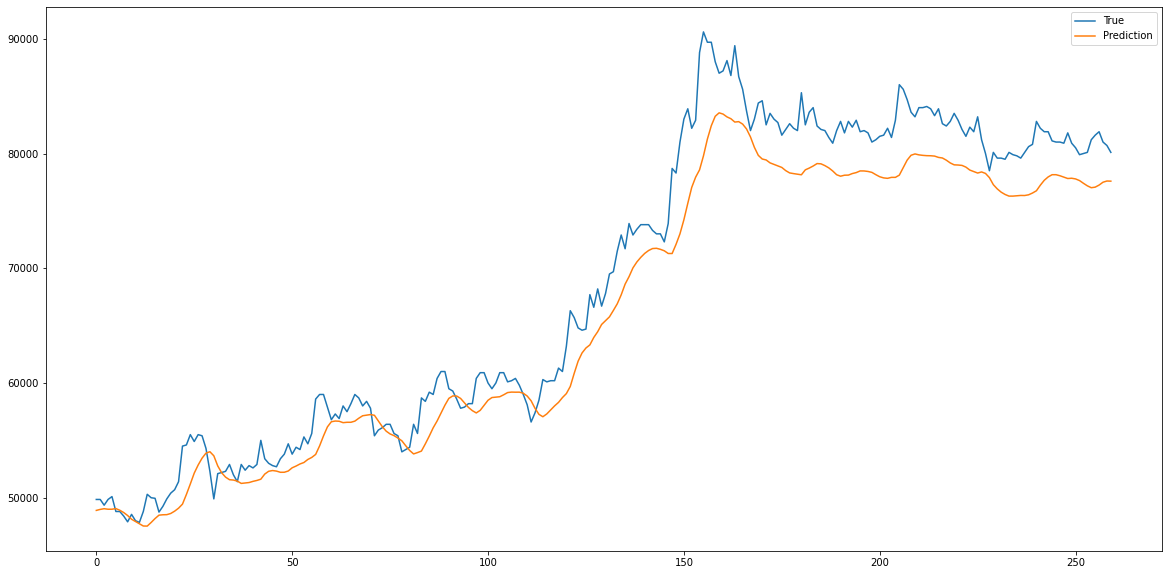

In [115]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()